# REINFORCE in TensorFlow

Just like we did before for Q-learning, this time we'll design a TensorFlow network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [25]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [26]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: we have received reports that the following cell may crash with `NameError: name 'base' is not defined`. The [suggested workaround](https://www.coursera.org/learn/practical-rl/discussions/all/threads/N2Pw652iEemRYQ6W2GuqHg/replies/te3HpQwOQ62tx6UMDoOt2Q/comments/o08gTqelT9KPIE6npX_S3A) is to install `gym==0.14.0` and `pyglet==1.3.2`.

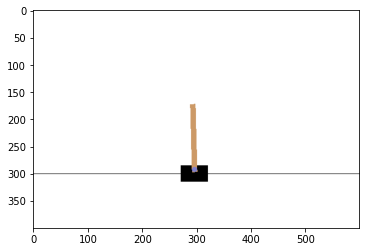

In [27]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [28]:
import tensorflow as tf

sess = tf.InteractiveSession()

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [29]:
# create input variables. We only need <s, a, r> for REINFORCE
ph_states = tf.placeholder('float32', (None,) + state_dim, name="states")
ph_actions = tf.placeholder('int32', name="action_ids")
ph_cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [31]:
from keras.models import Sequential
from keras.layers import Dense

#<YOUR CODE: define network graph using raw TF, Keras, or any other library you prefer>
network=Sequential()
network.add(Dense(units=128,input_shape=state_dim,activation="relu"))
network.add(Dense(units=64,activation="relu"))
network.add(Dense(units=32,activation="relu"))
network.add(Dense(units=16,activation="relu"))
network.add(Dense(units=n_actions,activation="linear"))
logits = network(ph_states)#<YOUR CODE: symbolic outputs of your network _before_ softmax>

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

In [32]:
# Initialize model parameters
sess.run(tf.global_variables_initializer())

In [33]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    return policy.eval({ph_states: [states]})[0]

### Play the game

We can now use our newly built agent to play the game.

In [48]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(s)

        # Sample action with given probabilities.
        #env.action_space.seed(seed=action_probs)
        a=np.random.choice(len(action_probs),p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [49]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [50]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cumul=len(rewards)*[0]
    for i in range(len(rewards)-1,-1,-1):
      if i==len(rewards)-1:
        cumul[i]=rewards[i]
        continue
      cumul[i]=rewards[i]+gamma*cumul[i+1]
    return cumul

In [51]:
print(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9))

[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0]


In [52]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse Tensorflow's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [53]:
# This code selects the log-probabilities (log pi(a_i|s_i)) for those actions that were actually played.
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), ph_actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [54]:
# Policy objective as in the last formula. Please use reduce_mean, not reduce_sum.
# You may use log_policy_for_actions to get log probabilities for actions taken.
# Also recall that we defined ph_cumulative_rewards earlier.

J = tf.reduce_mean((log_policy_for_actions * ph_cumulative_rewards), axis=-1)

As a reminder, for a discrete probability distribution (like the one our policy outputs), entropy is defined as:

$$ \operatorname{entropy}(p) = -\sum_{i = 1}^n p_i \cdot \log p_i $$

In [55]:
# Entropy regularization. If you don't add it, the policy will quickly deteriorate to
# being deterministic, harming exploration.

entropy =  -tf.reduce_mean(policy*log_policy)

In [56]:
# # Maximizing X is the same as minimizing -X, hence the sign.
loss = -(J + 0.1 * entropy)

update = tf.train.AdamOptimizer().minimize(loss)

In [57]:
def train_on_session(states, actions, rewards, t_max=1000):
    """given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        ph_states: states,
        ph_actions: actions,
        ph_cumulative_rewards: cumulative_rewards,
    })
    return sum(rewards)

In [58]:
# Initialize optimizer parameters
sess.run(tf.global_variables_initializer())

### The actual training

In [59]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions

    print("mean reward: %.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!")  # but you can train even further
        break

mean reward: 22.300
mean reward: 39.130
mean reward: 86.220
mean reward: 58.800
mean reward: 346.360
You Win!


### Results & video

In [ ]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [60]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'andrei.saceleanu@stud.acs.upb.ro', '7ABZ8gpehEseqKpu')

Your average reward is 233.39 over 100 episodes
Submitted to Coursera platform. See results on assignment page!


That's all, thank you for your attention!

Not having enough? There's an actor-critic waiting for you in the honor section. But make sure you've seen the videos first.